## g:profiler enrichment analysis evaluation 

updated the gene name. 
    
1. pick the smallest p val
    * pick the smallest p , then add JI requirement
    


In [10]:
LLM_score_thresh = 0.01 # only drop the ones LLM does not assign a name 
adj_pval_thresh = 0.05
JI_thresh = 0.05

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7, 'font.family': 'sans-serif'})
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['axes.labelsize'] = 7
plt.rcParams['axes.titlesize'] = 7

from utils.analyze_enrichment_utils import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data files from other analyses:
 - inputfile: LLM analyzed + gProfiler enrichment analysis on updated gene symbols
 - LLM coverage analysis - used GPT-4 to review the analysis text to determine which genes met the criteria that they are "definite" supports, not conjecture.
 - Best matching GO terms to LLM names, used to estimate how many genes match the name, enabling the computation of a JI

In [12]:

import pandas as pd
from utils.analyze_enrichment_utils import cal_JI_coverage

group_col = ["Source", "GeneSetID", "GeneSetName", "GeneList"] # group by these columns in future steps

## input file: LLM analyzed + gProfiler enrichment
updated_name_llm_file = 'data/omics_revamped_LLM_gprofiler_new_gene_name_DF.tsv'

# Read the TSV file into a Pandas DataFrame
LLM_genes_DF = pd.read_csv(updated_name_llm_file, delimiter="\t")
# make sure intersection_size, term_size, query_size are integers
LLM_genes_DF['intersection_size'] = LLM_genes_DF['intersection_size'].apply(lambda x: int(x))
LLM_genes_DF['term_size'] = LLM_genes_DF['term_size'].apply(lambda x: int(x))
LLM_genes_DF['query_size'] = LLM_genes_DF['query_size'].apply(lambda x: int(x))
#LLM_genes_DF.shape
LLM_genes_DF = cal_JI_coverage(LLM_genes_DF)
LLM_genes_DF.head(1)

,Source,GeneSetID,GeneSetName,GeneList,updated GeneList,n_Genes,LLM Name,LLM Analysis,Score,Term,GO ID,Adjusted P-value,intersection_size,term_size,query_size,intersections,gprofiler_JI,gprofiler_coverage
0,NeST,Cluster1-10,Cluster1-10,CTRL HSD17B14 KIAA0232 PAQR8 PLA2G1B RNF145 SG...,CTRL HSD17B14 KIAA0232 PAQR8 PLA2G1B RNF145 SG...,12,Lipid Metabolism and Membrane Dynamics,"1. CTRL, or carboxyl-terminal esterase/lipase,...",0.85,L-leucine import across plasma membrane,GO:1903801,0.080467,1,5,10,SLC7A8,0.071429,0.1


In [13]:
## load the LLM coverage data as a common df to merge
llm_coverage_df = pd.read_csv("data/omics_revamped_LLM_genecounts_DF.tsv", sep="\t")

llm_JI_file = 'data/omics_revamped_LLM_w_best_matching_GO_terms_for_JI.tsv'
llm_ji_df = pd.read_csv(llm_JI_file, sep="\t")

In [14]:
# merge with the LLM coverage data
merged_genes_DF = pd.merge(LLM_genes_DF, llm_coverage_df, on=['Source','GeneSetID','GeneSetName', 'GeneList', 'n_Genes'], how='left')
print(merged_genes_DF.shape)
# print(merged_genes_DF.columns)


# merge with the LLM JI data

merged_genes_DF = pd.merge(merged_genes_DF, llm_ji_df, on=['Source','GeneSetID','GeneList','n_Genes', 'LLM Name','Supporting Count'], how='left')
print(merged_genes_DF.shape)
print(merged_genes_DF.columns)

(53452, 23)
(53452, 28)
Index(['Source', 'GeneSetID', 'GeneSetName', 'GeneList', 'updated GeneList',
       'n_Genes', 'LLM Name', 'LLM Analysis', 'Score', 'Term', 'GO ID',
       'Adjusted P-value', 'intersection_size', 'term_size', 'query_size',
       'intersections', 'gprofiler_JI', 'gprofiler_coverage',
       'Supporting Genes', 'Supporting Count', 'LLM Support Analysis',
       'GenesMentionedInText', 'LLM_coverage', 'LLM_best_matching_GO',
       'best_matching_GO_ID', 'best_matching_GO_term_genes',
       'best_matching_GO_term_size', 'LLM_JI'],
      dtype='object')


# Pick Best APV

 - Select the best GO by the smallest p-value
 - Filter by p-value. 

If we later apply a coverage threshold to generate this curve, the curve will not change if the threshold is changed because the enriched term is not picked based on the coverage threshold

In [15]:
from utils.analyze_enrichment_utils import get_min_adj_p_value
%reload_ext autoreload
%autoreload 2

coverage_thresh = 0.2

# Grouping the DataFrame by the specified columns
grouped = merged_genes_DF.groupby(group_col)

# Apply the function to each group and reset the index
reduced_LLM_genes_APV_only_DF = grouped.apply(lambda x: get_min_adj_p_value(x, sortCol='gprofiler_JI')).reset_index(drop=True)

# Add the 'LLM_success_TF' and 'gprofiler_success_TF' columns
reduced_LLM_genes_APV_only_DF['LLM_success_TF'] = ((reduced_LLM_genes_APV_only_DF['Score'] >= LLM_score_thresh))
reduced_LLM_genes_APV_only_DF['gprofiler_success_TF'] = ~((reduced_LLM_genes_APV_only_DF['Adjusted P-value'] > adj_pval_thresh)) # enrichment criteria

print(create_success_contingency_table(reduced_LLM_genes_APV_only_DF))

result_df = select_rows_and_columns(reduced_LLM_genes_APV_only_DF, 5)
result_df


LLM_success_TF        True  False  Total
gprofiler_success_TF                    
True                   124    105    229
False                   11     60     71
Total                  135    165    300


,n_Genes,GeneList,LLM Name,Score,Term,GO ID,Adjusted P-value,intersection_size,term_size,intersections,gprofiler_coverage,LLM_coverage,gprofiler_JI,LLM_success_TF,gprofiler_success_TF
0,24,CITED2 COL5A1 CRABP2 KCTD12 MDFIC MMP2 NRP1 OR...,Cellular Matrix Remodeling and Tissue Development,0.85,collagen metabolic process,GO:0032963,0.005761,4,101,"COL5A1,MMP2,VIM,CST3",0.181818,0.21,0.033613,True,True
1,47,1060P11.3 ADM AHR AMIGO2 ARL4C ATP10D CAV2 CD4...,Cellular Adhesion and Extracellular Matrix Int...,0.85,inflammatory response,GO:0006954,0.001123,11,829,"1060P11.3,ADM,CAV2,CDC42EP3,EMP1,LPAR6,TRIB2,A...",0.250000,0.13,0.012761,True,True
2,59,ABAT ASS1 CHI3L1 CHST2 CLDN3 EIF5B FRZB GAL HE...,System of unrelated proteins,0.00,actomyosin structure organization,GO:0031032,0.005933,6,204,"AKR1B1,CAPN3,DKK1,MARCKS,MTUS1,OPN3",0.113208,NaN,0.023904,False,True
3,9,AMIGO2 AREG GAS6 GPR37 IFT57 PELI1 SQLE AKAP12...,System of unrelated proteins,0.00,regulation of oligodendrocyte apoptotic process,GO:1900141,0.000143,2,2,"GAS6,AKAP12",0.222222,NaN,0.222222,False,True
4,15,1060P11.3 CPE EFNB2 HIST1H2AC IL1R2 INHBB LYPD...,System of unrelated proteins,0.00,cellular response to interleukin-1,GO:0071347,0.000712,4,106,"H2AC6,IL1R2,NUP93,SOX9",0.285714,NaN,0.034483,False,True


In [7]:
# save the DataFrame to a TSV file
reduced_LLM_genes_APV_only_DF.to_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_DF_APV_only.tsv", sep="\t", index=False)

coverage threshold: 0.0, enrichment: 229.0, LLM: 135.0
coverage threshold: 0.05, enrichment: 84.0, LLM: 62.0
coverage threshold: 0.1, enrichment: 33.0, LLM: 42.0
coverage threshold: 0.2, enrichment: 4.0, LLM: 21.0


/cellar/users/mhu/Projects/llm_evaluation_for_gene_set_interpretation/utils/analyze_enrichment_utils.py:190: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(-8, 300)


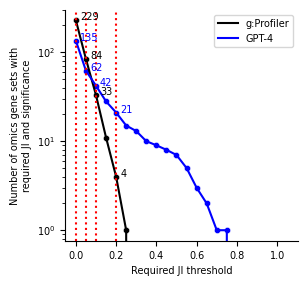

In [16]:
from utils.analyze_enrichment_utils import plot_thresholding_res
%reload_ext autoreload
%autoreload 2

plot_thresholding_res(reduced_LLM_genes_APV_only_DF, 'gprofiler_JI', 'LLM_JI',coverage_thresh_list = np.arange(0.0, 1.1, 0.05), enrich_adj_pval_thresh = adj_pval_thresh, LLM_score_thresh = LLM_score_thresh, highlight_coverage = [0.0, 0.05, 0.1, 0.2],figsize=(3,3), ax_label_keyword= 'JI', log_scale=True)

# Pick GO term with best APV then filter by JI thresholds 
 - Select the best GO term by the smallest p-value
      - If there are multiple GO terms with the same smallest p-value, then pick the term with the highest JI.
 - Filter by both the p-value and JI thresholds.


In [17]:
from utils.analyze_enrichment_utils import get_min_adj_p_value
%reload_ext autoreload
%autoreload 2

JI_thresh_list = [0.0, 0.05, 0.1, 0.2]
for JI_thresh in JI_thresh_list:
    print(f"JI threshold: {JI_thresh}")
    # Grouping the DataFrame by the specified columns
    grouped = merged_genes_DF.groupby(group_col)

    # Apply the function to each group and reset the index
    reduced_LLM_genes_APV_thred_JI_DF = grouped.apply(lambda x: get_min_adj_p_value(x, sortCol='gprofiler_JI')).reset_index(drop=True)


    # Add the 'LLM_success_TF' and 'gprofiler_success_TF' columns
    reduced_LLM_genes_APV_thred_JI_DF['LLM_success_TF'] = ((reduced_LLM_genes_APV_thred_JI_DF ['Score'] >= LLM_score_thresh)& (reduced_LLM_genes_APV_thred_JI_DF ['LLM_JI'] >= JI_thresh)) # LLM creteria
    reduced_LLM_genes_APV_thred_JI_DF['gprofiler_success_TF'] = ~((reduced_LLM_genes_APV_thred_JI_DF ['Adjusted P-value'] > adj_pval_thresh) | (reduced_LLM_genes_APV_thred_JI_DF['gprofiler_JI'] < JI_thresh)) # enrichment criteria


    print(create_success_contingency_table(reduced_LLM_genes_APV_thred_JI_DF))



JI threshold: 0.0
LLM_success_TF        True  False  Total
gprofiler_success_TF                    
True                   124    105    229
False                   11     60     71
Total                  135    165    300
JI threshold: 0.05
LLM_success_TF        True  False  Total
gprofiler_success_TF                    
True                    33     51     84
False                   29    187    216
Total                   62    238    300
JI threshold: 0.1
LLM_success_TF        True  False  Total
gprofiler_success_TF                    
True                    11     22     33
False                   31    236    267
Total                   42    258    300
JI threshold: 0.2
LLM_success_TF        True  False  Total
gprofiler_success_TF                    
True                     0      4      4
False                   21    275    296
Total                   21    279    300


# Heatmap for example

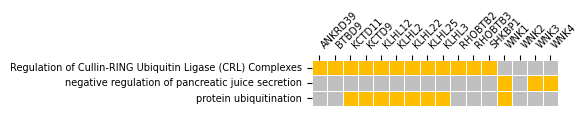

In [18]:
# find the GeneSetID: Cluster2-105 from the full table
example = merged_genes_DF.loc[
merged_genes_DF['GeneSetID'] == 'Cluster2-105'].iloc[[0,2]] # one is the most significant, one is more similar name
# example
geneList = example['GeneList'].values[0].split(' ')

new_cols = ['Name', 'Supporting Genes','Named by']
new_df = pd.DataFrame(columns=new_cols)

# LLM supporting genes
llm_supporting_genes = example['Supporting Genes'].values[0].split(' ')
# Join the LLM supporting genes list into a single string
llm_supporting_genes_str = ', '.join(llm_supporting_genes)
llm_name_row = pd.DataFrame({'Name': [example['LLM Name'].values[0]], 'Supporting Genes': llm_supporting_genes_str, 'Named by': ['GPT-4']})
new_df = pd.concat([new_df, llm_name_row], ignore_index=True)

for go_term in example['Term'].values:
    intersection = example.loc[example['Term'] == go_term, 'intersections'].values[0].split(',')
    # Join the intersection list into a single string
    intersection_str = ', '.join(intersection)
    new_row = pd.DataFrame({'Name': [go_term], 'Supporting Genes': intersection_str, 'Named by': ['g:Profiler']})
    new_df = pd.concat([new_df, new_row], ignore_index=True)


new_df = new_df.reset_index(drop=True)
# new_df
# geneList
# plot a heatmap, where columns are the genes and rows are the gene sets, heat at the intersections

# column is all the genes in the target gene set 
genes = set(geneList)
genes = sorted(genes)

# Create a binary matrix
matrix = pd.DataFrame(0, index=new_df['Name'], columns=genes)
for idx, row in new_df.iterrows():
    supporting_genes = row['Supporting Genes'].split(', ')
    matrix.loc[row['Name'], supporting_genes] = 1

# Calculate appropriate figure size based on the number of genes and gene sets
fig_height =len(new_df['Name']) * 0.2
fig_width= len(genes) * 0.2

# Plot the heatmap with square cells and adjusted figure size
plt.figure(figsize=(fig_width, fig_height))
ax = sns.heatmap(matrix, cmap=['#c0c0c0', '#ffbd00'], cbar=False, linewidths=.5, annot=False, square=True)
# Move the x-axis labels to the top
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

# Adjust the font size of the labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='left')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')


plt.xlabel('')
plt.ylabel('')
plt.savefig('figures/omics_LLM_gprofiler_CULLIN_example_gene_intersection_heatmap.svg', dpi=300)
plt.show()